In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import json

In [3]:
from collections import defaultdict

In [4]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    style='whitegrid', # стиль figure
    font_scale=3, # размер шрифта
    rc={
#         'lines.linewidth': 3, # ширина линий
        'text.usetex' : True # использовать tex
    } 
)

In [6]:
from visualization_utils import visualize

In [7]:
with open('data_new.pkl', 'rb') as f:
    results = pickle.load(f)

In [8]:
with open('viz_data_new.pkl', 'rb') as f:
    (X, Y) = pickle.load(f)

In [9]:
classes = defaultdict(list)
for i, y in enumerate(Y):
    tag = y.split('_')[-1][:-1]
    classes[tag].append(i)
classes

defaultdict(list,
            {'S2': [0,
              1,
              2,
              16,
              17,
              18,
              32,
              33,
              34,
              48,
              49,
              50,
              64,
              65,
              66,
              80,
              81,
              82,
              96,
              97,
              98,
              112,
              113,
              114,
              128,
              129,
              130,
              144,
              145,
              146,
              160,
              161,
              162,
              176,
              177,
              178,
              192,
              193,
              194,
              208,
              209,
              210,
              224,
              225,
              226,
              240,
              241,
              242],
             'C2': [3,
              4,
              5,
              19,
            

In [10]:
func_dirs = set([r['tag'] for r in results if r['tag'][-1] in ['X', 'Y', 'Z']])
func_dirs

{'C2X',
 'C2Y',
 'C2Z',
 'L2X',
 'L2Y',
 'L2Z',
 'S2X',
 'S2Y',
 'S2Z',
 'SS2X',
 'SS2Y',
 'SS2Z'}

In [11]:
funcs = set([r['tag'][:-1] for r in results if r['tag'][-1] in ['X', 'Y', 'Z']])
funcs

{'C2', 'L2', 'S2', 'SS2'}

In [12]:
def make_data(results):
    X, X_f, Y = [], [], []
    for r in results:
        X.append(np.array(r['x']).reshape(1, -1))
        X_f.append(np.array(r['exp_data']).reshape(1, -1))
        Y.append(r['dir_name'] + ' ' + r['tag'])
    X = np.concatenate(X, axis=0)
    X_f = np.concatenate(X_f, axis=0)
    return X, X_f, Y

In [13]:
def enumerate_stacks(Y):
    unique_labels = set([y.split(' ')[0] for y in Y])
    labels_map = {item: i + 1  for i, item in enumerate(sorted(unique_labels))}
    labels = []
    for y in Y:
        if ' ' not in y:
            stack, tag = y, ''
        else:
            stack, tag = y.split(' ', 1)
        labels.append('{stack} {tag}'.format(stack=labels_map[stack], tag=tag))
    return labels

In [14]:
from functools import cmp_to_key

def order_stacks(X, X_f, Y):
    def cmp(a, b):
        a = a[-1]
        b = b[-1]
        a, aa = a.split(' ', 1)
        a = int(a)
        b, bb = b.split(' ', 1)
        b = int(b)
        if (a > b) or ((a == a) and (aa > bb)):
            return 1
        elif (a == b) and (aa == bb):
            return 0
        else:
            return -1
        
    new_X, new_X_f, new_Y = [], [], []
    for x, x_f, y in sorted(zip(X, X_f, Y), key=cmp_to_key(cmp)):
#         print(x.shape)
        new_X.append(x.reshape(1, -1))
        new_X_f.append(x_f.reshape(1, -1))
        new_Y.append(y)
    return np.concatenate(new_X, axis=0), np.concatenate(new_X_f, axis=0), new_Y

## Выбираем из данных фиксированную корр функцию, и для неё берём все образцы и все направления

In [15]:
funcs = {('C2', '$C_{2}$'), 
         ('L2', '$L_{2}$'),
         ('S2', '$S_{2}$'),
         ('SS2', '$SS_{2}$')}

In [16]:
def trunc_Y(Y, dirs=True):
    if dirs:
        dirs_map = {
            'X': '$X$',
            'Y': '$Y$',
            'Z': '$Z$',
        }
    else:
        dirs_map = {
            'X': '',
            'Y': '',
            'Z': '',
        }
    new_Y = []
    for y in Y:
        y = y.replace(f, '')
        for k, v in dirs_map.items():
            y = y.replace(k, v)
        new_Y.append(y)
    return new_Y

In [17]:
funcs

{('C2', '$C_{2}$'), ('L2', '$L_{2}$'), ('S2', '$S_{2}$'), ('SS2', '$SS_{2}$')}

In [18]:
# new_Y
scalers = {}
for f, _ in funcs:
    filtered_results = [r for r in results if r['tag'].startswith(f) and (r['tag'] != f)]
    X, X_f, Y = make_data(filtered_results)
    scalers[f] = StandardScaler().fit(X)
    scalers[f + '_f'] = StandardScaler().fit(X_f)

In [19]:
categories_2 = [
    'arable',
    'post arable',
    'arable',
    'arable',
    'arable',
    'arable',
    'arable',
    'arable',
    'post arable',
    'arable',
    'arable',
    'arable',
    'arable',
    'arable',
    'arable',
    'post arable',
]
categories_3 = [
    'bare fallow',
    'afforestation',
    'cereals',
    'cereals',
    'bare fallow',
    'bare fallow',
    'bare fallow',
    'bare fallow',
    'afforestation',
    'cereals',
    'cereals',
    'cereals',
    'cereals',
    'cereals',
    'cereals',
    'afforestation'
]

In [20]:
Y

['2 L2X',
 '2 L2Y',
 '2 L2Z',
 '12 L2X',
 '12 L2Y',
 '12 L2Z',
 '1 L2X',
 '1 L2Y',
 '1 L2Z',
 '8 L2X',
 '8 L2Y',
 '8 L2Z',
 '3 L2X',
 '3 L2Y',
 '3 L2Z',
 '7 L2X',
 '7 L2Y',
 '7 L2Z',
 '10 L2X',
 '10 L2Y',
 '10 L2Z',
 '6 L2X',
 '6 L2Y',
 '6 L2Z',
 '4 L2X',
 '4 L2Y',
 '4 L2Z',
 '14 L2X',
 '14 L2Y',
 '14 L2Z',
 '9 L2X',
 '9 L2Y',
 '9 L2Z',
 '11 L2X',
 '11 L2Y',
 '11 L2Z',
 '5/down_part900 L2X',
 '5/down_part900 L2Y',
 '5/down_part900 L2Z',
 '5/upper_part900 L2X',
 '5/upper_part900 L2Y',
 '5/upper_part900 L2Z',
 '13/down L2X',
 '13/down L2Y',
 '13/down L2Z',
 '13/upper L2X',
 '13/upper L2Y',
 '13/upper L2Z']

In [ ]:
for f, tex in funcs:
    filtered_results = [r for r in results 
                        if r['tag'].startswith(f) 
                            and (r['tag'][-1] in ['X', 'Y', 'Z'])]
    print('Func: {}'.format(f))
    print('Tags : {}'.format(str(set([item['tag'] for item in filtered_results]))))
    X, X_f, Y = make_data(filtered_results)
    Y = enumerate_stacks(Y)
    X, X_f, Y = order_stacks(X, X_f, Y)
    Y = trunc_Y(Y)
    print('Data shapes: {}, {}'.format(X.shape, len(Y)))
    visualize(X, X_f, Y, categories=(categories_2, categories_3), scalers=scalers, exp_name=f, tex=tex, ns=[2, 3, 6, 10], fdir='vis_results', dpi=400)

## Выбираем из данных фиксированную корр функцию и направление и для неё берём все образцы

In [26]:
pairs = []
for item in func_dirs:
    pos = item.find('2')
    s = '$' + item[:pos] + '_{{ {s} }}'.format(s=item[pos:]) + '$'
    pairs.append((item, s))
pairs = set(pairs)
pairs

{('C2X', '$C_{ 2X }$'),
 ('C2Y', '$C_{ 2Y }$'),
 ('C2Z', '$C_{ 2Z }$'),
 ('L2X', '$L_{ 2X }$'),
 ('L2Y', '$L_{ 2Y }$'),
 ('L2Z', '$L_{ 2Z }$'),
 ('S2X', '$S_{ 2X }$'),
 ('S2Y', '$S_{ 2Y }$'),
 ('S2Z', '$S_{ 2Z }$'),
 ('SS2X', '$SS_{ 2X }$'),
 ('SS2Y', '$SS_{ 2Y }$'),
 ('SS2Z', '$SS_{ 2Z }$')}

In [23]:
for f, tex in pairs:
    filtered_results = [r for r in results if r['tag'].startswith(f)]
    print('Func: {}'.format(f))
    print('Tags : {}'.format(str(set([item['tag'] for item in filtered_results]))))
    X, X_f, Y = make_data(filtered_results)
    Y = enumerate_stacks(Y)
    X, X_f, Y = order_stacks(X, X_f, Y)
    Y = trunc_Y(Y, dirs=False)
    print('Data shapes: {}, {}'.format(X.shape, len(Y)))
    visualize(X, X_f, Y,
              scalers, 
              exp_name=f, 
              tex=tex, 
              ns=[2, 3, 6, 10], 
              fdir='vis_results', 
              dpi=400)

Func: S2Y
Tags : {'S2Y'}
Data shapes: (16, 6), 16
Func: C2Y
Tags : {'C2Y'}
Data shapes: (16, 6), 16
Func: C2X
Tags : {'C2X'}
Data shapes: (16, 6), 16
Func: S2Z
Tags : {'S2Z'}
Data shapes: (16, 6), 16
Func: SS2Z
Tags : {'SS2Z'}
Data shapes: (16, 6), 16
Func: SS2X
Tags : {'SS2X'}
Data shapes: (16, 6), 16
Func: S2X
Tags : {'S2X'}
Data shapes: (16, 6), 16
Func: L2Y
Tags : {'L2Y'}
Data shapes: (16, 6), 16
Func: L2X
Tags : {'L2X'}
Data shapes: (16, 6), 16
Func: SS2Y
Tags : {'SS2Y'}
Data shapes: (16, 6), 16
Func: L2Z
Tags : {'L2Z'}
Data shapes: (16, 6), 16
Func: C2Z
Tags : {'C2Z'}
Data shapes: (16, 6), 16


## Визуализируем усредненные по трём направлениям корр функции для каждого образца

In [ ]:
for f, tex in funcs:
    filtered_results = [r for r in results 
                        if r['tag'].startswith(f) 
                            and (r['tag'][-1] not in ['X', 'Y', 'Z'])]
    print('Func: {}'.format(f))
    print('Tags : {}'.format(str(set([item['tag'] for item in filtered_results]))))
    X, X_f, Y = make_data(filtered_results)
    Y = enumerate_stacks(Y)
    X, X_f, Y = order_stacks(X, X_f, Y)
    Y = trunc_Y(Y, dirs=False)
    print('Data shapes: {}, {}'.format(X.shaype, len(Y)))

    visualize(X, X_f, Y, 
              scalers,
              exp_name='{}_mean'.format(f), 
#               title='mean',
              tex=tex, 
              ns=[2, 3, 6, 10], 
              fdir='vis_results', 
              dpi=400)

Func: S2
Tags : {'S2'}
Data shapes: (16, 6), 16
Func: SS2
Tags : {'SS2'}
Data shapes: (16, 6), 16
Func: L2
Tags : {'L2'}
Data shapes: (16, 6), 16
Func: C2
Tags : {'C2'}
Data shapes: (16, 6), 16


## Вытягиваем все корр функции для каждого стека в один длинный вектор, чтобы найти "расстояние" между стеками

In [21]:
def make_func_dirs(results, scalers, use_tag=True):
    stacks = defaultdict(dict)
    order = []
        
    accepted_tags = set()
    for r in results:
        stack_name = r['dir_name']
        tag = r['tag']
        # Пропускаем усредненные по всем направлениям корр функции
        if tag[-1] in ['X', 'Y', 'Z']:
            continue
        accepted_tags.add(tag)
        stacks[stack_name][tag] = {
            'x': r['x'],
            'exp_data': r['exp_data']
        }
        order.append(tag)
    print('Accepted tags: {}'.format(str(accepted_tags)))
    order = sorted(set(order))
    X, X_f, Y = [], [], []
    for stack_name, stack in stacks.items():
        Y.append(stack_name)
        x = []
        x_f = []
        for tag in order:
            x_to = np.array(stack[tag]['x']).reshape(1, -1)
            x_f_to = np.array(stack[tag]['exp_data']).reshape(1, -1)
            if scalers is not None:
                if not use_tag:
                    tag = 'all'
                x_to = scalers[tag].transform(x_to)
                x_f_to = scalers[tag + '_f'].transform(x_f_to)
            x.append(x_to)
            x_f.append(x_f_to)
        X.append(np.concatenate(x).reshape(1, -1))
        X_f.append(np.concatenate(x_f).reshape(1, -1))
    X = np.concatenate(X, axis=0)
    X_f = np.concatenate(X_f, axis=0)
    return X, X_f, Y

In [22]:
X, X_f, Y = make_func_dirs(results, scalers=scalers)
Y = enumerate_stacks(Y)
X, X_f, Y = order_stacks(X, X_f, Y)

Accepted tags: {'SS2', 'L2', 'C2', 'S2'}


In [23]:
print('Data shapes: {}, {}'.format(X.shape, len(Y)))

Data shapes: (16, 24), 16


In [24]:
from visualization_utils import visualize

In [35]:
visualize(
    X, 
    X_f, 
    Y,
    categories=(categories_2, categories_3),
    scalers=None,
    exp_name='stacks', 
    tex='stacks',
    ns=[2, 3, 6, 10], 
    fdir='vis_results', 
    dpi=400,
    use_title=False
)

In [20]:
from sklearn.metrics import pairwise_distances
import numpy as np
import pandas as pd
import scipy as sp

In [68]:
data_functions_2 = [
    ([0 ,0], '1 ', 0),
    ([31, 2.9], '2 ', 1),
    ([-6, 2.1], '3 ', 2),
    ([-11.9, -3.7], '4 ', 2),
    ([-11, -0.6], '5 ', 2),
    ([-13, -1.95], '6 ', 2),
    ([-7, 6], '7 ', 2),
    ([12, -2.7], '8 ', 1),
    ([6, -2.9], '9 ', 1),
    ([-8.3, -2.14], '10 ', 2),
    ([18.5, 0.6], '11 ', 1),
    ([-10.2, 0.4], '12 ', 2),
    ([-6, 0.18], '13 ', 2),
    ([14, -0.6], '14 ', 1),
    ([8, -1.7], '15 ', 1),
    ([-13, 4], '16 ', 2)
]

data_functions_3 = [
    ([0 ,0], '1 ', 0),
    ([31, 2.9], '2 ', 3),
    ([-6, 2.1], '3 ', 2),
    ([-11.9, -3.7], '4 ', 2),
    ([-11, -0.6], '5 ', 2),
    ([-13, -1.95], '6 ', 2),
    ([-7, 6], '7 ', 2),
    ([12, -2.7], '8 ', 1),
    ([6, -2.9], '9 ', 1),
    ([-8.3, -2.14], '10 ', 2),
    ([18.5, 0.6], '11 ', 1),
    ([-10.2, 0.4], '12 ', 2),
    ([-6, 0.18], '13 ', 2),
    ([14, -0.6], '14 ', 1),
    ([8, -1.7], '15 ', 1),
    ([-13, 4], '16 ', 2)
]

In [75]:
data_parameters_2 = [
    ([0 ,0], '1 ', 0),
    ([3.1, -0.2], '2 ', 1),
    ([0.2, 0.1], '3 ', 2),
    ([-1.7, 0.15], '4 ', 2),
    ([-0.2, 0.53], '5 ', 2),
    ([-2.23, -0.19], '6 ', 2),
    ([2.1, 2.69], '7 ', 1),
    ([-0.09, -0.94], '8 ', 2),
    ([0.1, -0.29], '9 ', 2),
    ([-1.7, 1.2], '10 ', 2),
    ([1.3, -1.4], '11 ', 2),
    ([-0.9, 1.1], '12 ', 2),
    ([-0.96, -0.5], '13 ', 2),
    ([0.84, -1.78], '14 ', 2),
    ([-0.37, -1.28], '15 ', 2),
    ([0.48, 0.85], '16 ', 2)
]

data_parameters_3 = [
    ([0 ,0], '1 ', 0),
    ([3.1, -0.2], '2 ', 3),
    ([0.2, 0.1], '3 ', 2),
    ([-1.7, 0.15], '4 ', 1),
    ([-0.2, 0.53], '5 ', 1),
    ([-2.23, -0.19], '6 ', 1),
    ([2.1, 2.69], '7 ', 2),
    ([-0.09, -0.94], '8 ', 3),
    ([0.1, -0.29], '9 ', 3),
    ([-1.7, 1.2], '10 ', 1),
    ([1.3, -1.4], '11 ', 3),
    ([-0.9, 1.1], '12 ', 1),
    ([-0.96, -0.5], '13 ', 1),
    ([0.84, -1.78], '14 ', 3),
    ([-0.37, -1.28], '15 ', 3),
    ([0.48, 0.85], '16 ', 2)
]

In [46]:
len(categories_2)

16

In [50]:
categories_3

['bare fallow',
 'afforestation',
 'cereals',
 'cereals',
 'bare fallow',
 'bare fallow',
 'bare fallow',
 'bare fallow',
 'afforestation',
 'cereals',
 'cereals',
 'cereals',
 'cereals',
 'cereals',
 'cereals',
 'afforestation']

In [48]:
len(categories_2)

16

In [66]:
from visualization_utils import plot_heatmap, plot_clusters

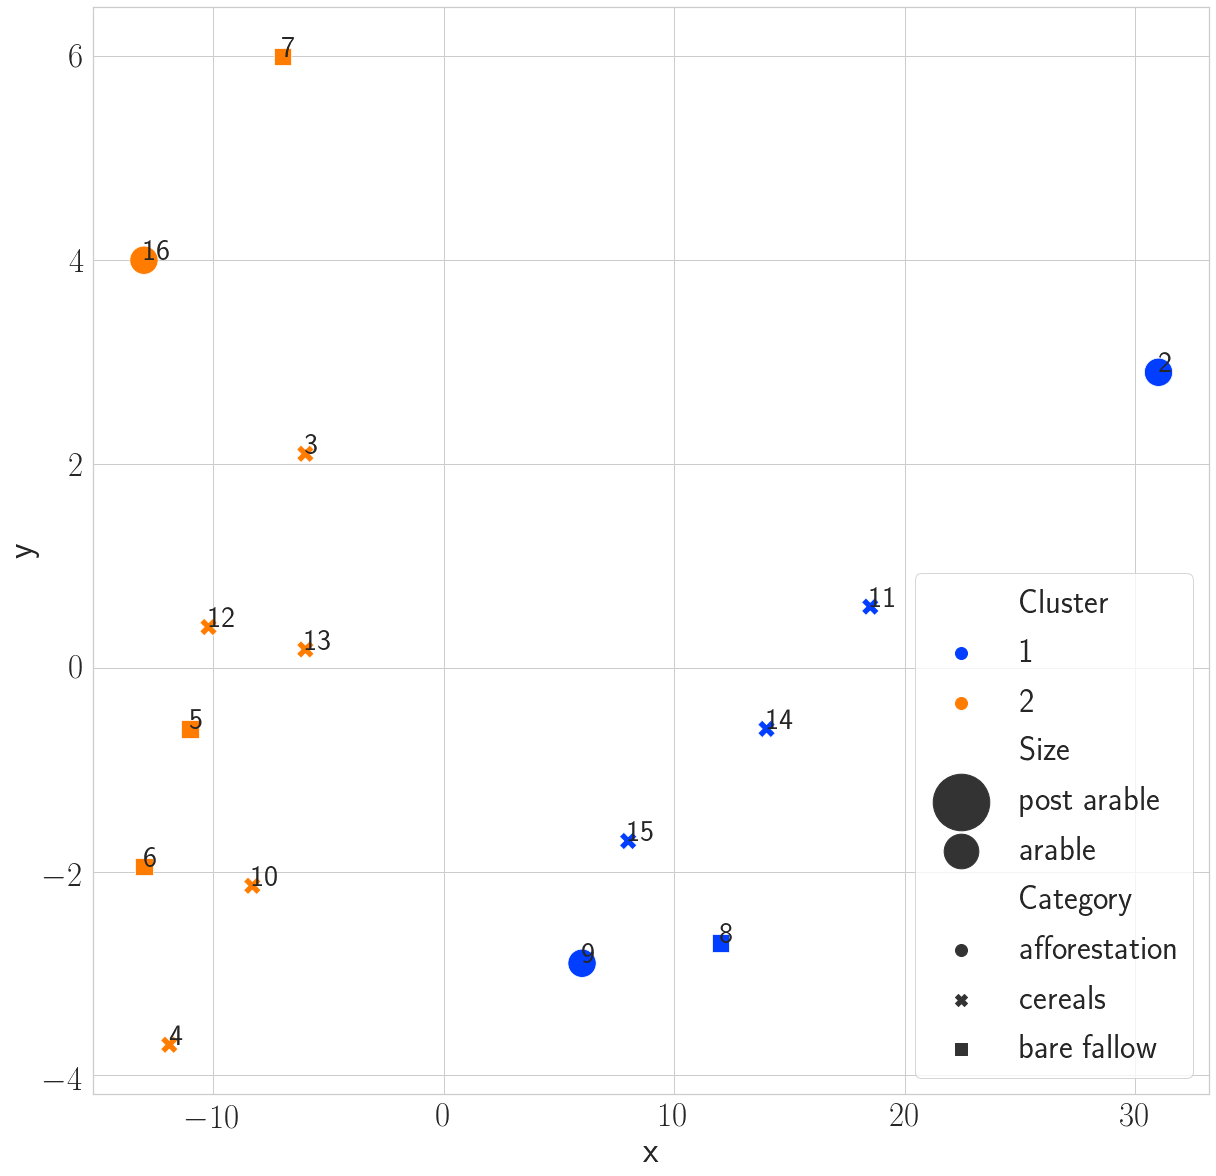

In [79]:
X, Y, clusters = [], [], []
for x, y, c in data_functions_2:
    X.append(x)
    Y.append(y)
    clusters.append(c)
X = np.array(X)
Y = np.array(Y)
clusters = np.array(clusters)

plot_clusters(
    X=X, 
    Y=Y, 
    clusters=clusters, 
    categories=categories_3, 
    sizes=categories_2,
    exp_name='stacks',
    tex='stacks',
    title='functions', 
    n=2, 
    use_pca=False,
    fdir='.', 
    dpi=400, 
    use_title=False
)

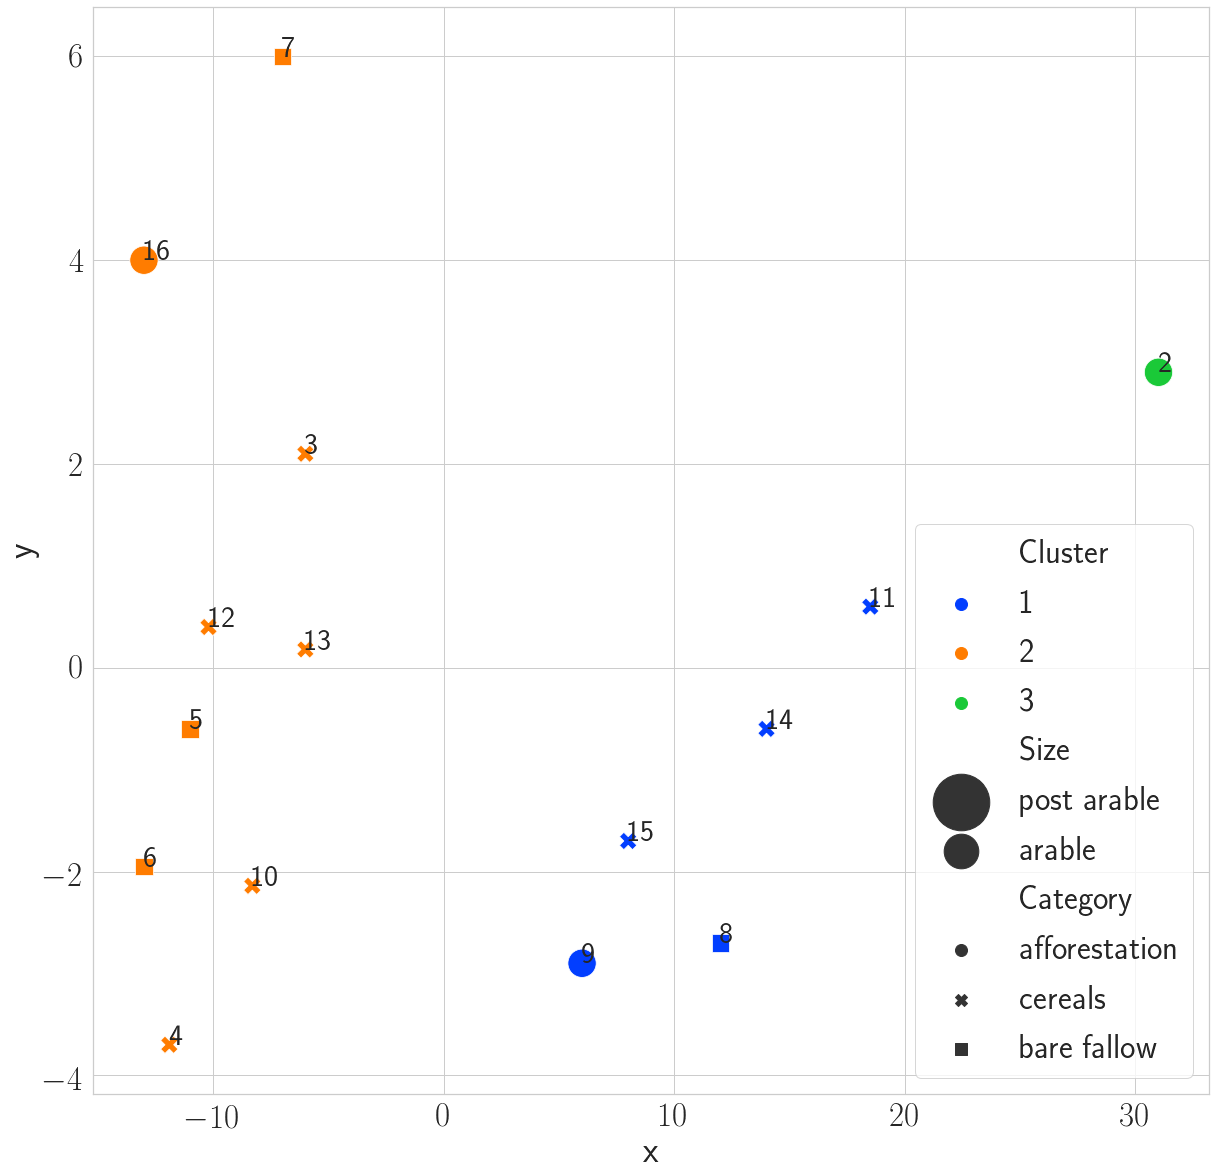

In [80]:
X, Y, clusters = [], [], []
for x, y, c in data_functions_3:
    X.append(x)
    Y.append(y)
    clusters.append(c)
X = np.array(X)
Y = np.array(Y)
clusters = np.array(clusters)

plot_clusters(
    X=X, 
    Y=Y, 
    clusters=clusters, 
    categories=categories_3, 
    sizes=categories_2,
    exp_name='stacks',
    tex='stacks',
    title='functions', 
    n=3, 
    use_pca=False,
    fdir='.', 
    dpi=400, 
    use_title=False
)

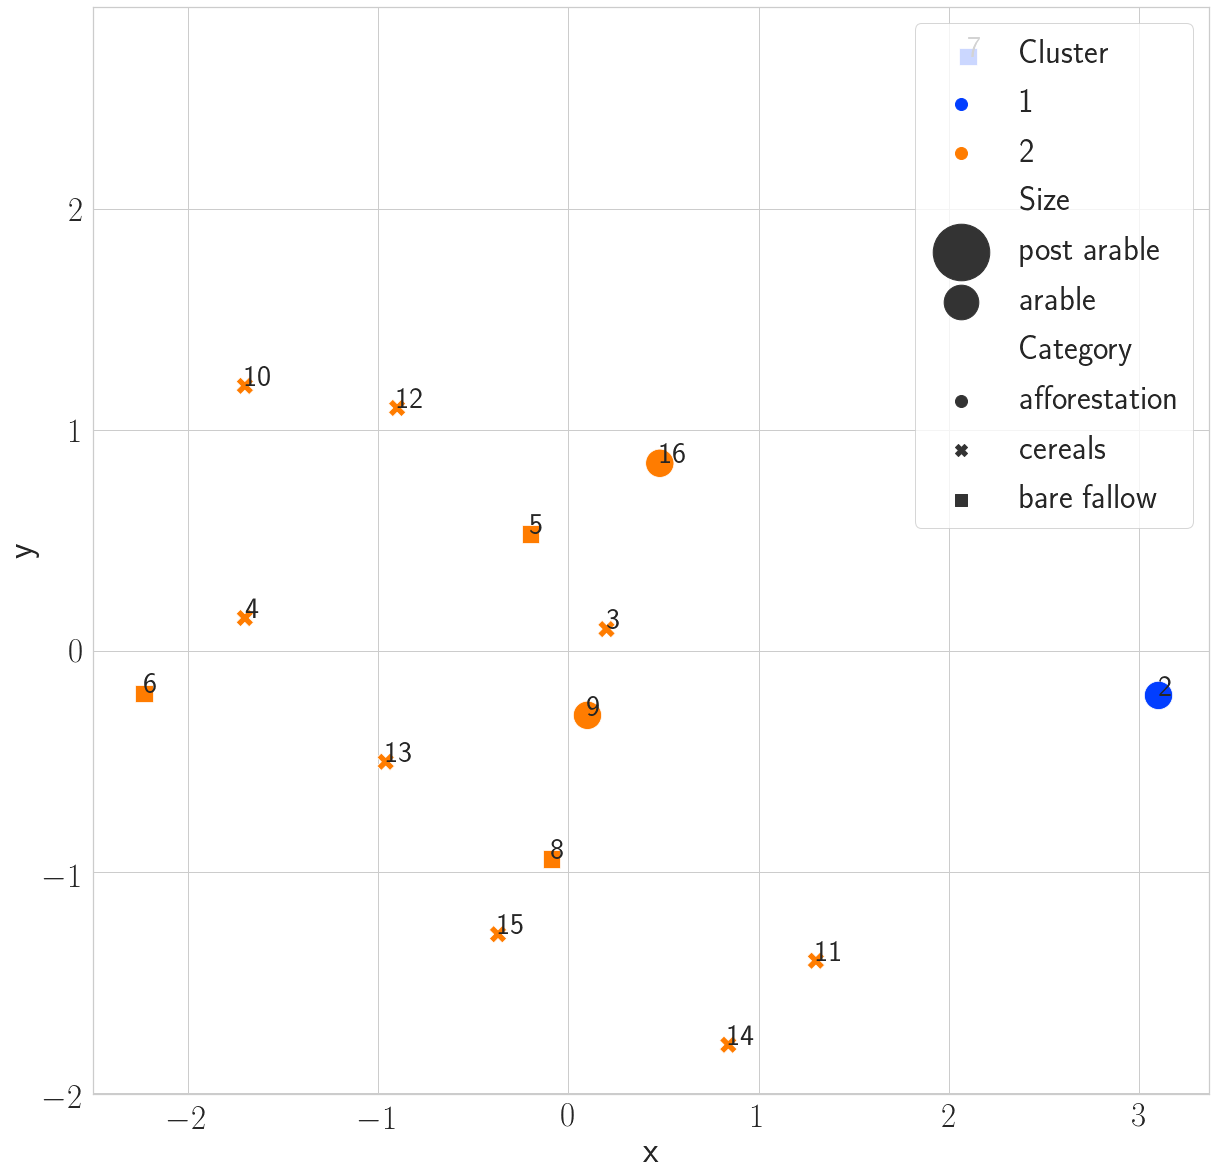

In [77]:
X, Y, clusters = [], [], []
for x, y, c in data_parameters_2:
    X.append(x)
    Y.append(y)
    clusters.append(c)
X = np.array(X)
Y = np.array(Y)
clusters = np.array(clusters)

plot_clusters(
    X=X, 
    Y=Y, 
    clusters=clusters, 
    categories=categories_3, 
    sizes=categories_2,
    exp_name='stacks',
    tex='stacks',
    title='parameters', 
    n=2, 
    use_pca=False,
    fdir='.', 
    dpi=400, 
    use_title=False
)

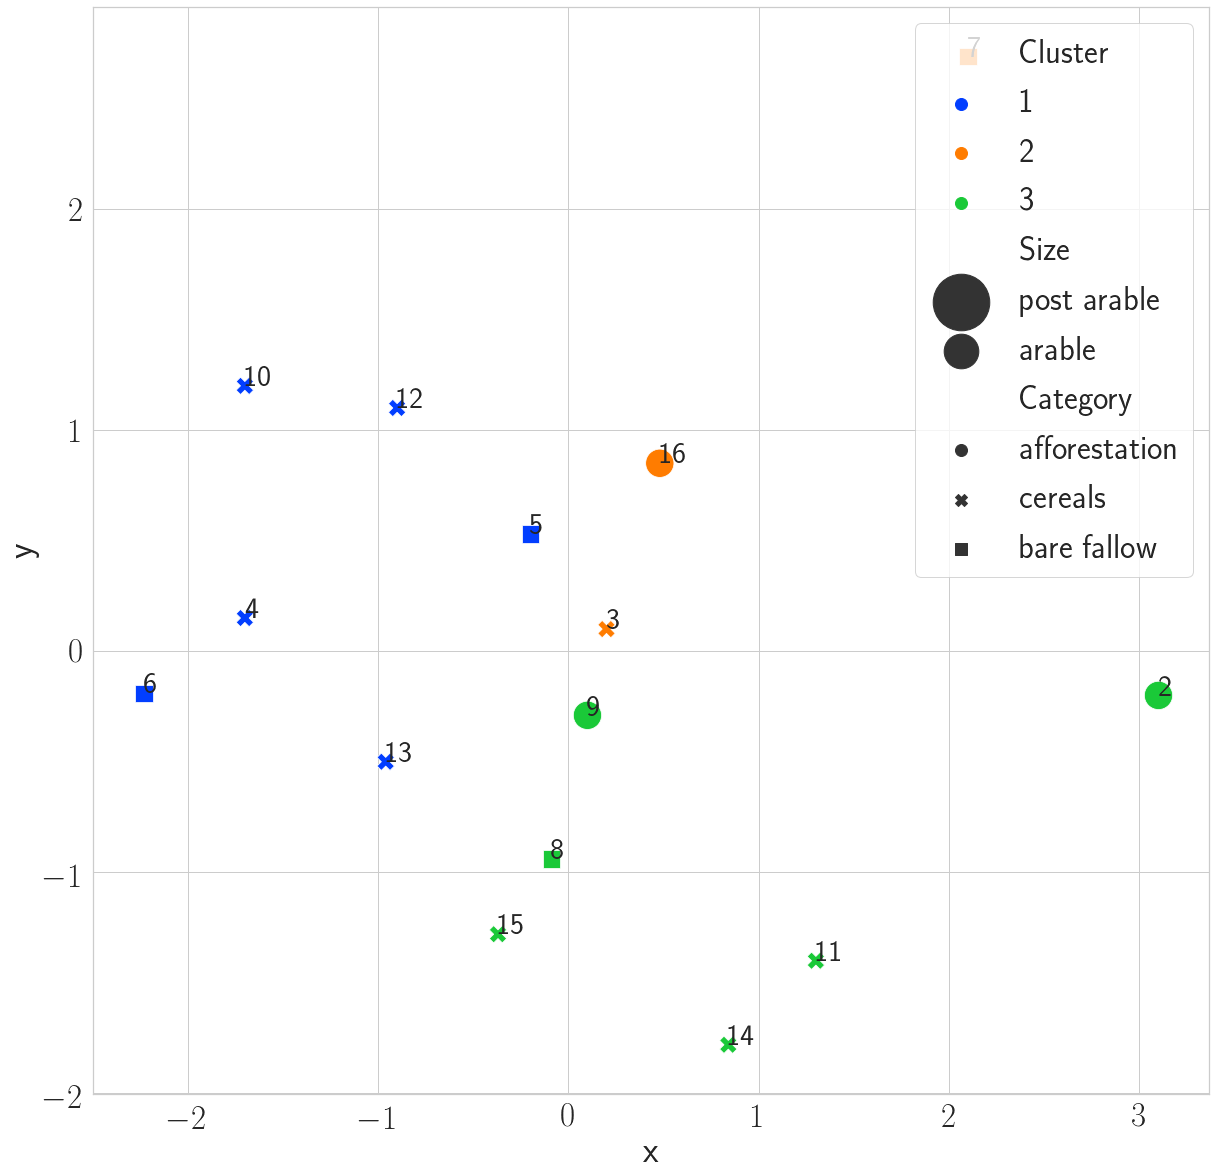

In [78]:
X, Y, clusters = [], [], []
for x, y, c in data_parameters_3:
    X.append(x)
    Y.append(y)
    clusters.append(c)
X = np.array(X)
Y = np.array(Y)
clusters = np.array(clusters)

plot_clusters(
    X=X, 
    Y=Y, 
    clusters=clusters, 
    categories=categories_3, 
    sizes=categories_2,
    exp_name='stacks',
    tex='stacks',
    title='parameters', 
    n=3, 
    use_pca=False,
    fdir='.', 
    dpi=400, 
    use_title=False
)

## Визуализация PCA и Kmeans для всех коррфункций и всех направлений

In [24]:
import os

In [53]:
with open('viz_data.pkl', 'rb') as f:
    (X, Y) = pickle.load(f)

In [60]:
X_normalized = StandardScaler().fit_transform(X)

In [61]:
pca = PCA(n_components=2, random_state=42)
X_embedded = pca.fit_transform(X_normalized)

In [62]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X_normalized)
clusters = kmeans.predict(X_normalized)

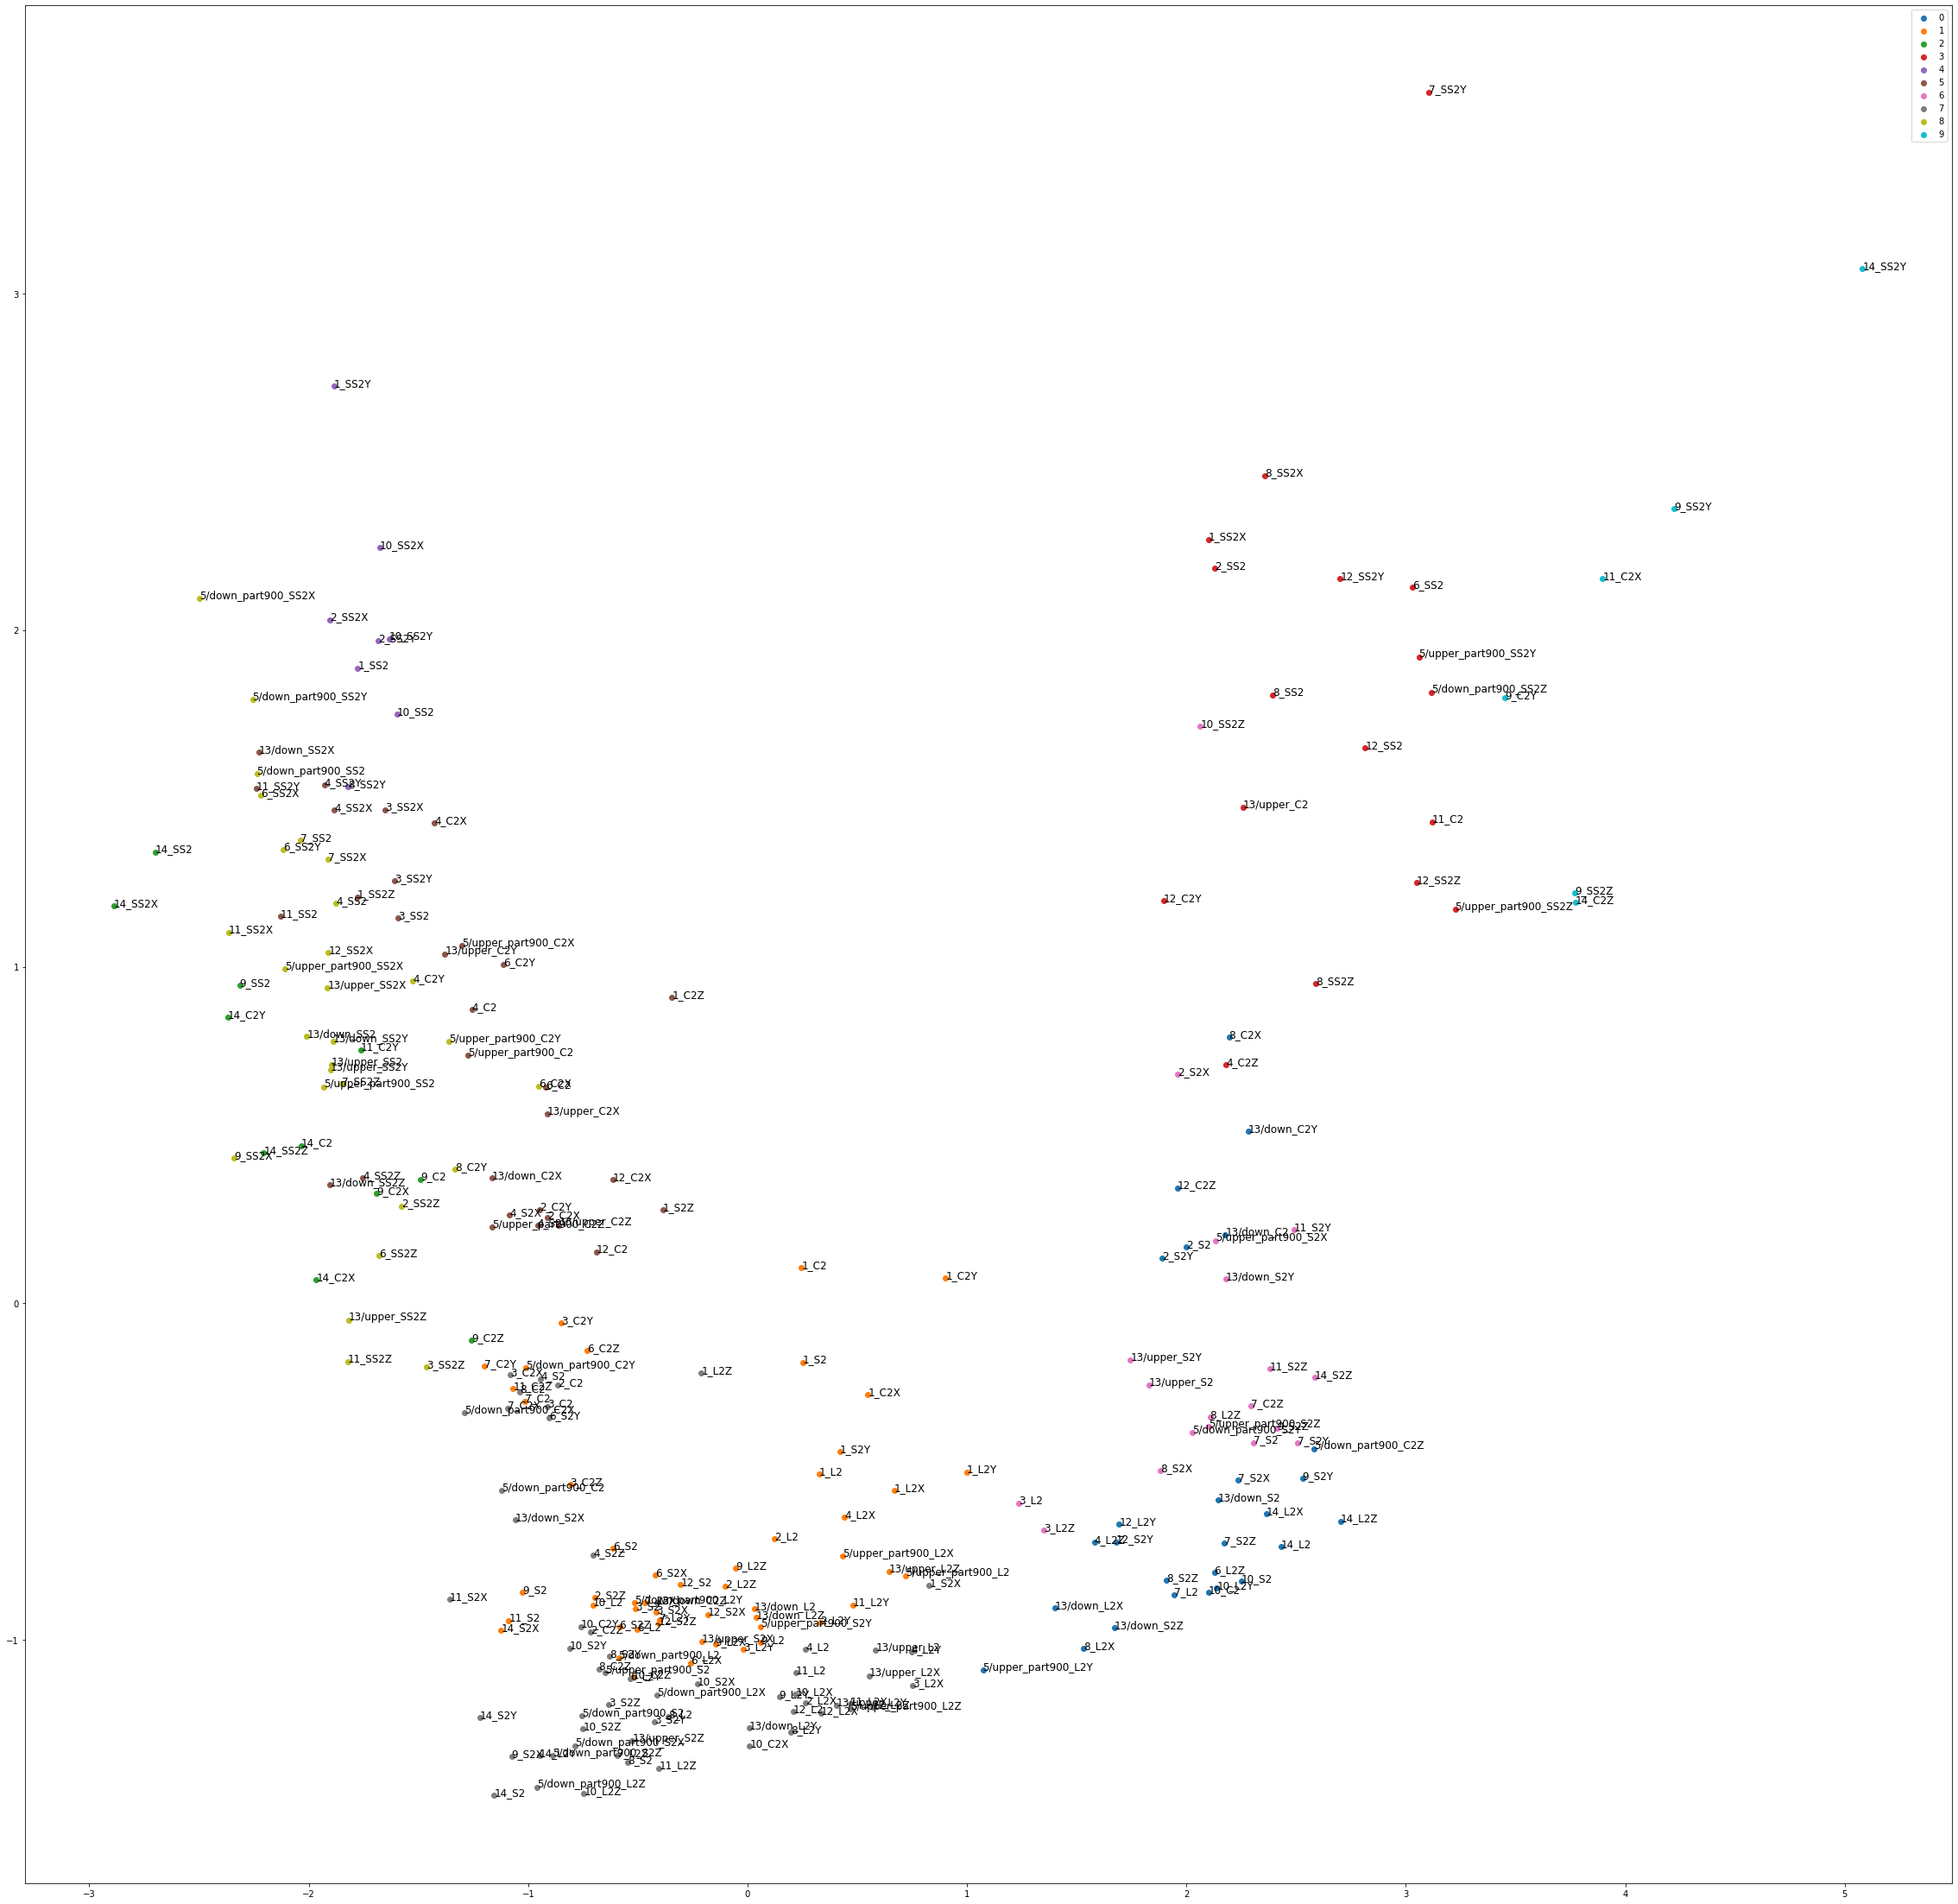

In [64]:
plt.figure(figsize=(40, 40))
for i in range(10):
    idxes,  = np.where(clusters == i)
    plt.scatter(X_embedded[idxes, 0], X_embedded[idxes, 1], label=str(i))
for i, y in enumerate(Y):
    plt.annotate(y, (X_embedded[i, 0], X_embedded[i, 1]), fontsize=12)
plt.legend(loc='best')
plt.savefig(os.path.join('vis_results', 'clustering.png'))
plt.show()

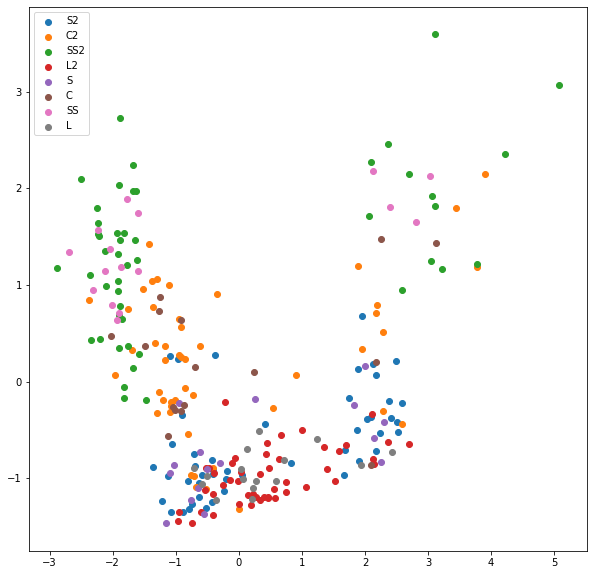

In [65]:
plt.figure(figsize=(10, 10))
for cls, idxes in classes.items():
    plt.scatter(X_embedded[idxes, 0], X_embedded[idxes, 1], label=cls)
plt.legend(loc='best')
plt.savefig(os.path.join('vis_results', 'func_small.png'))
plt.show()

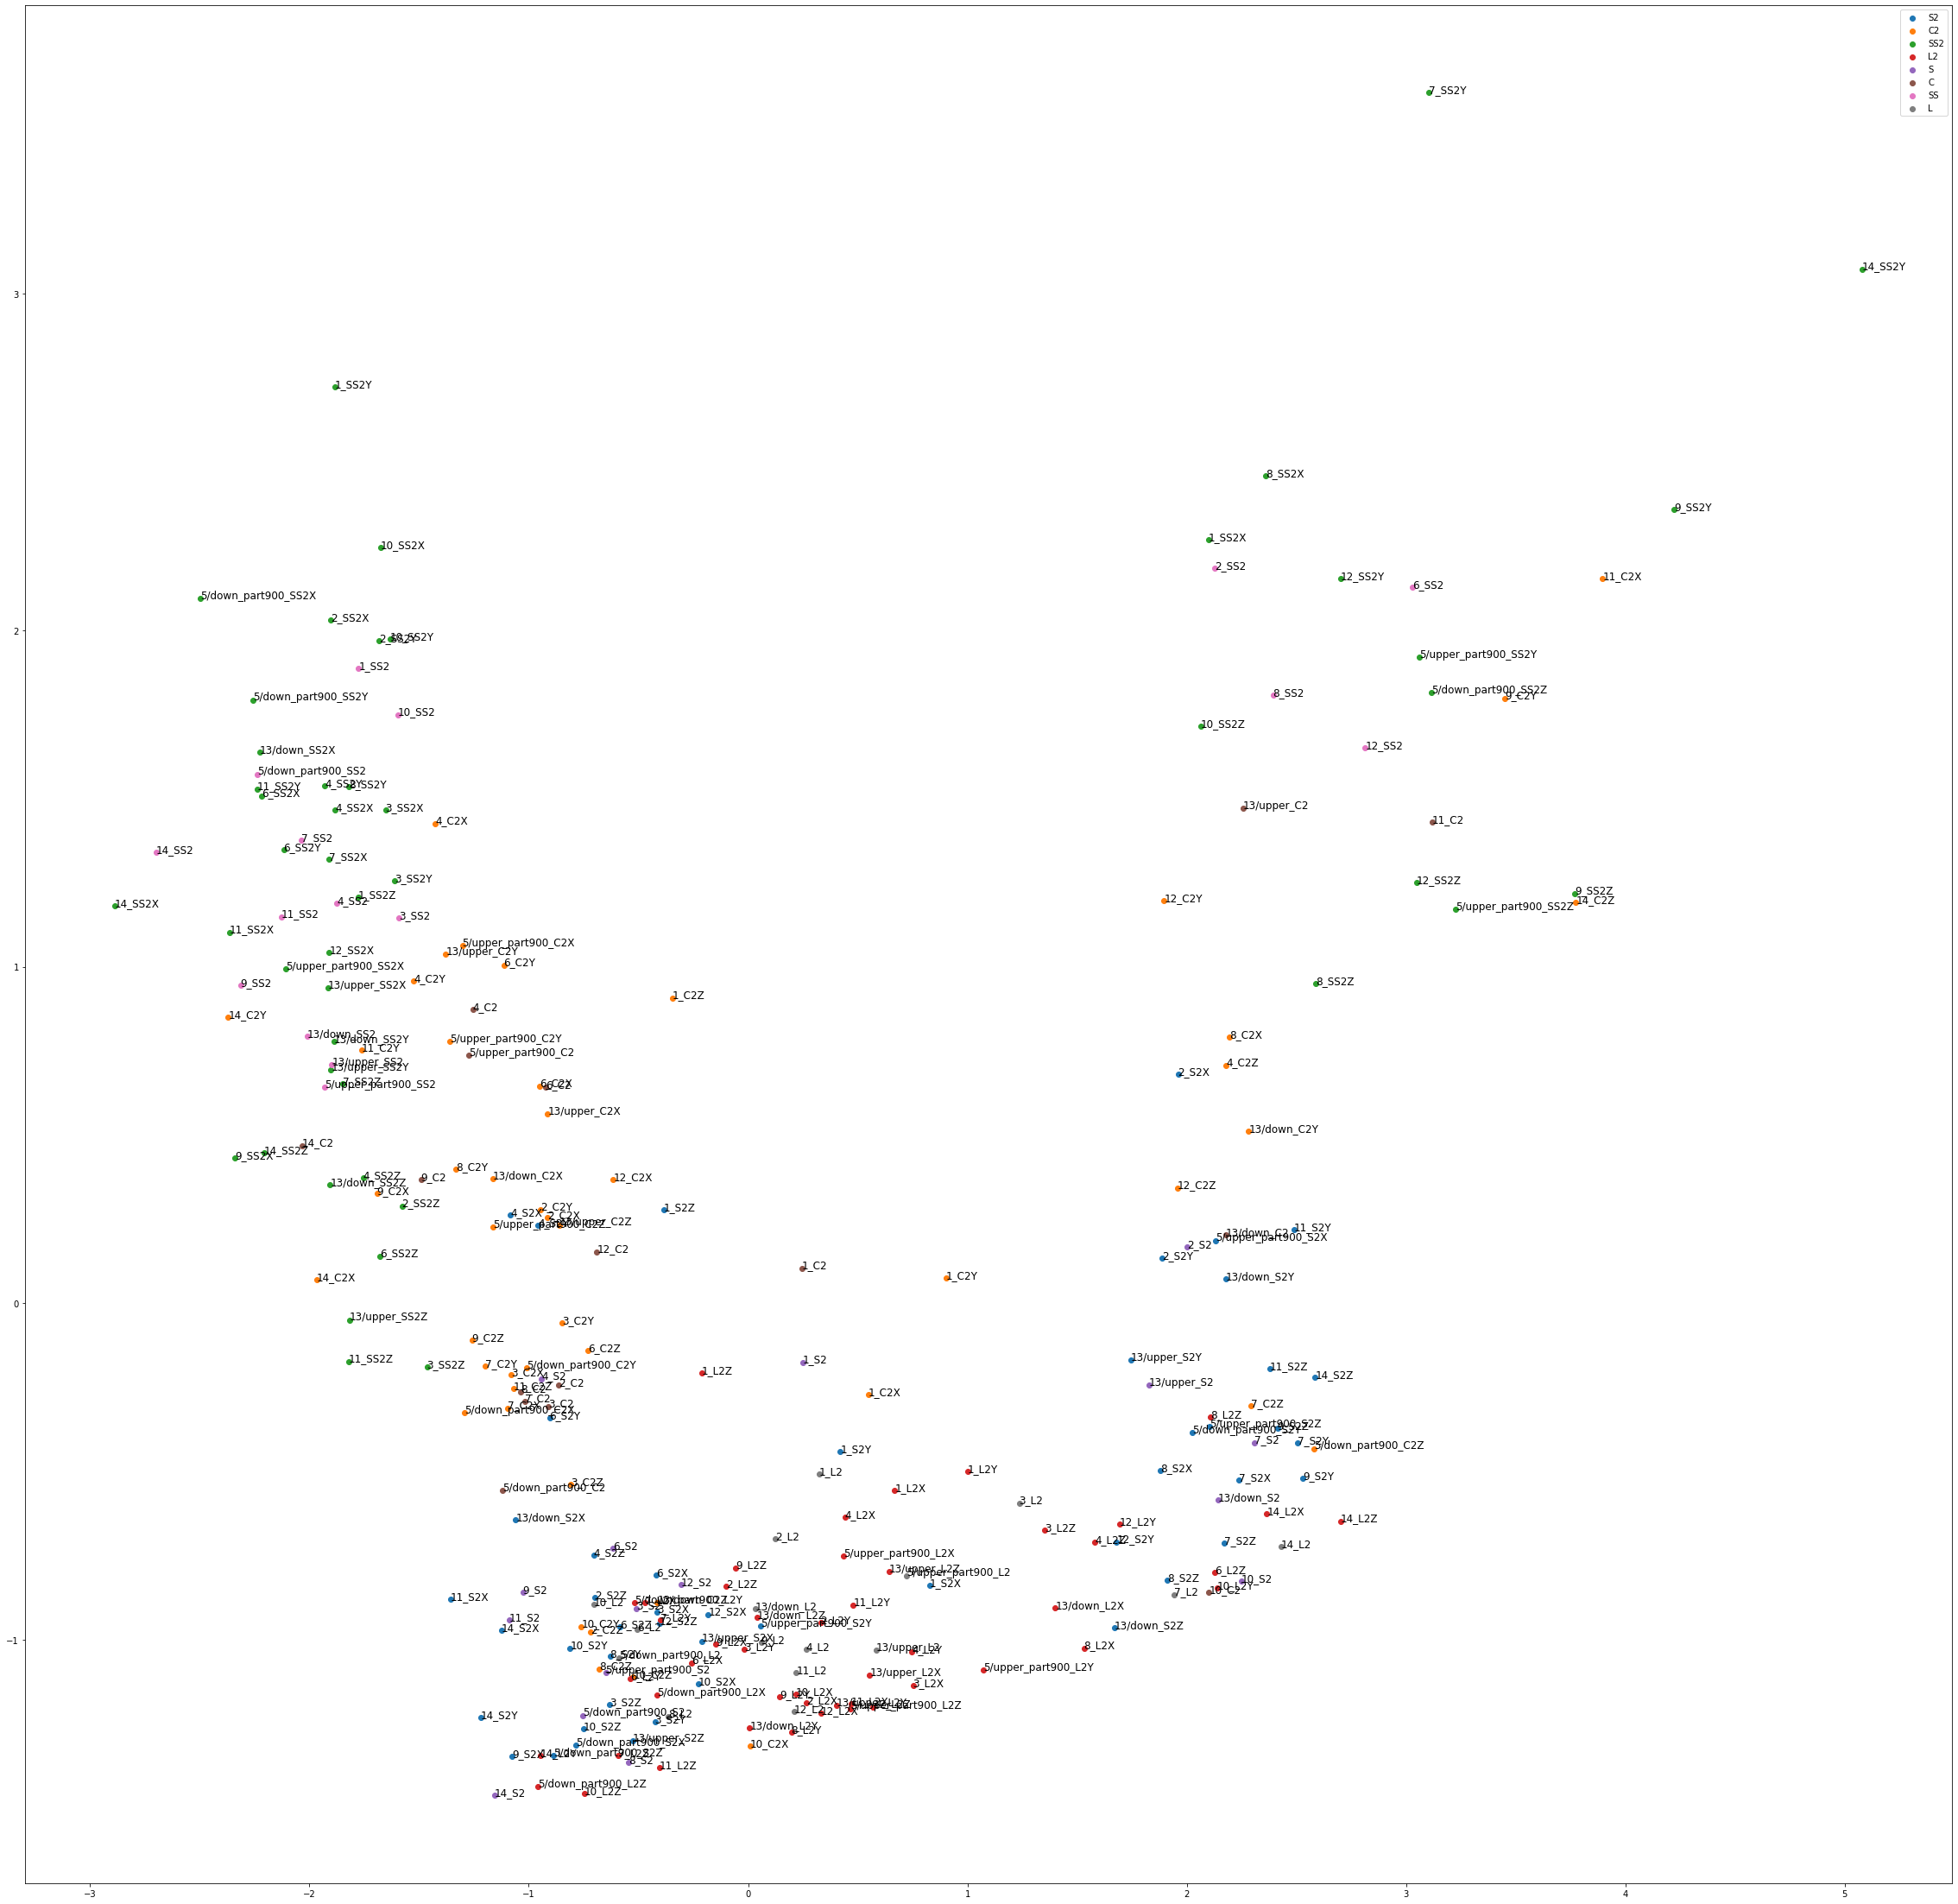

In [66]:
plt.figure(figsize=(40, 40))
for cls, idxes in classes.items():
    plt.scatter(X_embedded[idxes, 0], X_embedded[idxes, 1], label=cls)
for i, y in enumerate(Y):
    plt.annotate(y, (X_embedded[i, 0], X_embedded[i, 1]), fontsize=12)
plt.legend(loc='best')
plt.savefig(os.path.join('vis_results', 'func.png'))
plt.show()